# Best GB Model

This is the best GB model. The model was trained/tuned in the following ways:
training set: 20162 - 20182
validation sets: 20191 - 20192
test set: 20201

model val average LC20 (20192 & 20192): 37.8%
model test LC20: 40.1%

The function to recreate this dataset for these models is provided. The original datasets for training and testing are also provided.

In [1]:
from CUSP_functions import generate_featureset
from CUSP_functions import evaluator
from CUSP_functions import lc20_scorer
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, PredefinedSplit, cross_val_score
from sklearn.pipeline import Pipeline
path = 'data/'

## generate dataset

## global parameters

In [2]:
train_periods = [20162, 20171, 20172, 20181, 20182, 20191, 20192]
test_period = [20201]

# Best model

## dataset parameters:
includes all 'A' set features
includes moving rolling average
predicting normalized rank, with 'min' method applied for ties
does not have any spatial aggregatioon 
standardization and kernel PCA with 8 degree poly kernel

The original dataset for training was: dataset_v4_0711_160345_A_rank_stand_kpca_roll_shift_min.pkl

This dataset can be generated using featureset_generatore_v3 and the following params.

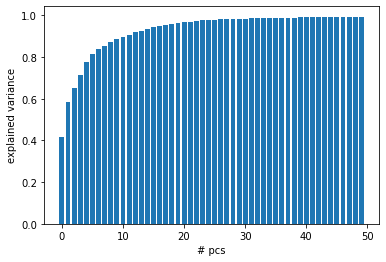

dataset_v4_0726_203439_A_rank_stand_kpca_roll_shift_min.pkl
total_features: 145


In [3]:
#generate dataset
dataset_1 = generate_featureset('A', 'rank', 'pkl', scale = 'standardize', roll_avg = True, 
                    pca = 'kpca', shift = True, train_periods = train_periods,
                   test_periods = test_period, ties = 'min', geo = False, spatial = False)

In [6]:
#set the columns that we don't want (not all of these cols are in the dataset, but just to be safe check all)
exclude = ['year', 'period', 'period_geoid', 'overdose_count','label', 'y', 'x_coord', 'y_coord']
dataset_1 = dataset_1.loc[ : , ~dataset_1.columns.isin(exclude) ]

target_var = 'overdose_rank' #set target variable

num_components = 16 #set number of components - optimal number determined via validation set performance
comp_list = ['pc' + str(i) for i in range(1, num_components + 1)] #create list for filtering components

#separate training and test sets
X_train_1 = dataset_1.loc[ dataset_1.full_period.isin(train_periods) , comp_list]
y_train_1 = dataset_1.loc[ dataset_1.full_period.isin(train_periods) , target_var]

X_test_1 = dataset_1.loc[ dataset_1.full_period.isin(test_period) ,  comp_list ]
y_test_1 = dataset_1.loc[ dataset_1.full_period.isin(test_period) , target_var ]

#extract geoids from test set for evaluation
y_test_1_geoid = dataset_1.loc[ dataset_1.full_period.isin(test_period) , 'geoid' ].to_numpy()

#run model with best params
regr = XGBRegressor(random_state = 123,
                            max_depth = 2,
                            subsample = 0.5,
                            min_child_weight = 4,
                            n_estimators = 100,
                            eta = 0.05)

regr.fit(X_train_1, y_train_1) #fit to data

# predicting rank percentile
y_test_1_predict = regr.predict(X_test_1)

#run through evaluator
test_acc, targets_df = evaluator(y_test_1_predict, y_test_1_geoid, test_period[0], num_periods_predicted =1, eval_index = 1, simple = True)


0.04386535721657259


In [7]:
test_acc.head()

,UC,LC
% targeted,,
5%,13.4,10.2
10%,26.2,21.9
15%,33.7,34.2
20%,38.5,40.1


# To tune a new model

The above model uses the best parameters found using the below tuning method. If a model with new tuning is desired, use the below code block. The current parameter grid takes 1.2-2.5 hours to run.

In [ ]:
target_var = 'overdose_rank'

#specify number of components
num_components = 16
comp_list = ['pc' + str(i) for i in range(1, num_components + 1)]

full_rf = dataset.copy()
full_rf['y'] = full_rf['overdose_rank'] #separate out target
full_rf['period_geoid'] = full_rf['full_period'].astype(str) + '_' +  full_rf['geoid'].astype(str) #this is going to be passed into the custom scorer as the "signal" - period and geoid
full_rf.set_index('period_geoid', inplace = True)

# to make sure each period's record stay together
full_rf.sort_index(ascending = True, inplace = True)

train_val_period = [20162, 20171, 20172, 20181, 20182, 20191, 20192] #inclusive of validation periods
test_period = [20201]
val_periods = [20191, 20192]

#seprate out features we definitely don't want, just to be safe
not_include = ['year', 'period', 'geoid', 'full_period', 'period_geoid', 'overdose_rank', 'overdose_count','label', 'y', 'x_coord', 'y_coord']

#get combined training and validation set
X_train_val = full_rf[full_rf.full_period.isin(train_val_period)].loc[:, comp_list]
y_train_val = full_rf[full_rf.full_period.isin(train_val_period)].loc[:, 'y']

#get test set
X_test = full_rf[full_rf.full_period.isin(test_period)].loc[:,  comp_list]
y_test_geoid = full_rf[full_rf.full_period.isin(test_period)].loc[:, 'geoid'].to_numpy()
y_test = full_rf[full_rf.full_period.isin(test_period)].loc[:, 'y']

pipeline = Pipeline([('XGBoost', XGBRegressor(random_state = 123))])

#this can be tweaked to include a wider range of parameters but will take longer to complete
parameters = {'XGBoost__eta': [0.001, 0.01, 0.05, .1],
              'XGBoost__n_estimators': [100, 150, 200],
              'XGBoost__min_child_weight': range(1,6, 1),
              'XGBoost__subsample': [0.5, 1.],
              'XGBoost__max_depth': range(1, 6, 1)
             }
    
lc20 = make_scorer(lc20_scorer, greater_is_better = True) #instantiate lc20 scorer for validaton

num_train_periods = len(train_val_period)
num_val_periods = len(val_periods) * 2
train_val_split = [-1 for i in range(0, 811*(num_train_periods - 2))] + [0 for i in range(num_val_periods)] #indicate the split

cv = PredefinedSplit(test_fold = train_val_split )
#cv = KFold(n_splits = 2, shuffle = False)

grid_search = GridSearchCV(pipeline, parameters, verbose = 10,  cv = cv, n_jobs = 24, scoring = lc20)
grid_search.fit(X_train_val, y_train_val)
print(grid_search.best_score_)
print(grid_search.best_params_)

In [ ]:
#call best estimator
best_regr = grid_search.best_estimator_

# predicting rank percentile
y_test_predict = best_regr.predict(X_test)

# evaluating the test
y_test_predict_df = pd.DataFrame({'geoid': y_test_geoid, 'y': y_test_predict})

test_acc, df = evaluator(y_test_predict, np.array(y_test_geoid), test_period[0], num_periods_predicted = 1, eval_index = 1)
capture = test_acc.loc['20%', 'LC']
print(capture)